# Further Classification

In this notebook we will look at further aspects of classification, including performing a robust evaluation of a classifier.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# imports for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

For this example, we will use the [*Diabetes* dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set), originally collected by the US National Institute of Diabetes. Given a set of patient diagnostic measurements, the objective of this task is to predict whether or not the patient has diabetes. The features in the data are as follows:

- *preg*: Number of times the patient has been pregnant
- *plasma*: Plasma glucose concentration
- *pres*: Diastolic blood pressure
- *skin*: Triceps skin fold thickness
- *insulin*: 2-Hour serum insulin level
- *bmi*: Body mass index 
- *family*: Score likelihood of diabetes based on family history
- *age*: The patient's age in years
- *outcome*: The actual diagnosis for the patient ('positive' or 'negative')


## Data Loading and Preparation

Load the complete dataset from a CSV file:

In [6]:
df = pd.read_csv('diabetes.csv')
df.head()

,preg,plasma,pres,skin,insulin,bmi,family,age,outcome
0,6,148,72,35,0,33.6,0.627,50,positive
1,1,85,66,29,0,26.6,0.351,31,negative
2,8,183,64,0,0,23.3,0.672,32,positive
3,1,89,66,23,94,28.1,0.167,21,negative
4,0,137,40,35,168,43.1,2.288,33,positive


Look at the distribution of the target label 'outcome' in the data:

In [8]:
df["outcome"].value_counts()

outcome
negative    485
positive    254
Name: count, dtype: int64

Separate out the features to use for classification from the target label itself:

In [10]:
target = df["outcome"].values
other_columns = list(df.columns)
other_columns.remove("outcome")
print(other_columns)
data = df[other_columns]
data.head()

['preg', 'plasma', 'pres', 'skin', 'insulin', 'bmi', 'family', 'age']


,preg,plasma,pres,skin,insulin,bmi,family,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


Finally, we will apply normalisation to the numeric data. In this case, the variables are mean centered and scaled by the standard deviation:

In [12]:
normalizer = StandardScaler()
data_scaled = normalizer.fit_transform(data.values)
data_scaled

array([[ 0.65326149,  0.85505112,  0.15876751, ...,  0.21588701,
         0.46624186,  1.44162863],
       [-0.8441338 , -1.11352839, -0.14824302, ..., -0.66918472,
        -0.36554523, -0.17928005],
       [ 1.25221961,  1.9487064 , -0.25057986, ..., -1.08643282,
         0.60185932, -0.09396907],
       ...,
       [-1.14361286,  0.16761065,  0.87512542, ..., -0.56803366,
         0.12870507, -1.03238988],
       [ 1.25221961, -1.73847427,  0.15876751, ...,  0.0135849 ,
         0.38487138,  0.75914077],
       [-0.54465474, -0.67606628, -0.45525355, ...,  0.59520347,
        -0.05814565, -1.03238988]])

## Evaluation Metrics

We will now look at different ways to evaluate a classification algorithm. We will focus on the case of *binary classification* (two classes) using the diabetes data, although these methods generalise to *multi-class* problems.

As we've seen previously, we can easily randomly split the complete dataset into a training test and a test set. We will specify that 40% (0.4) of the data will be used for the test set. The remaining 60% will be used to train the model.

In [15]:
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, test_size=0.4)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 443 examples
Test set has 296 examples


Now we will build a KNN classifier (*k=3* neighbours) based on the training data:

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
m = knn.fit(data_train, target_train)

Make our predictions on the test set and evaluate them using the standard classification *accuracy* score:

In [19]:
predicted = knn.predict(data_test)
# calculate the accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.733


Accuracy scores only provide us with a single score summarising a classifier's performance. Often we want to understand where a classifier performs well or poorly in more detail.

In particular, we might want to determine the extent to which the classifier made the following correct/incorrect predictions:
- *True Positives* (TP) are those which are labeled 'positive' which are actually 'positive'
- *False Positives* (FP) are those which are labeled 'positive' which are actually 'negative'
- *True Negatives* (TN) are those which are labeled 'negative' which are actually 'negative'
- *False Negatives* (FN) are those which are labeled 'negative' which are actually 'positive'

We can do this by creating a confusion matrix for the results. The result is a NumPy matrix, with predictions on the columns and actual labels on the rows. The values correspond to:

    [ [TP FN]
    [FP TN] ]
A perfect classifier with 100% accuracy would produce a pure diagonal matrix which would have all the test examples predicted in their correct class. In our case, we see that we have many false negatives (i.e. examples labelled -1 which are actually 1).

In [21]:
from sklearn.metrics import confusion_matrix
# build the confusion matrix
cm = confusion_matrix(target_test, predicted)
print(cm)

[[163  38]
 [ 41  54]]


We can produce a more visual version of this matrix using the *ConfusionMatrixDisplay* class:

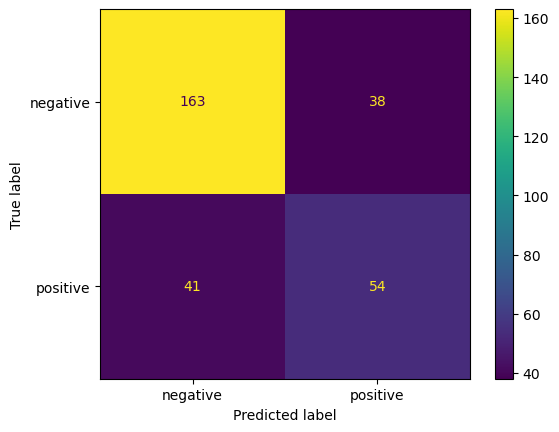

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
# note we get the labels (names) for the classes from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot();

Measures from information retrieval (search engines) can be used in ML evaluation. Note that these are calculated with respect to a particular class (e.g. positive class or the negative class):
- *Precision*: proportion of retrieved results that are relevant = TP/(TP+FP)
- *Recall*: proportion of relevant results that are retrieved = TP/(TP+FN)

In [25]:
from sklearn.metrics import precision_score, recall_score
# indicate that we are interested in the Positive class here
print("Precision(Positive) = %.3f" % precision_score(target_test, predicted, pos_label="positive") )
print("Recall(Positive) = %.3f" % recall_score(target_test, predicted, pos_label="positive") )

Precision(Positive) = 0.587
Recall(Positive) = 0.568


In [26]:
# alternatively indicate that we are interested in the Negative class here
print("Precision(Negative) = %.3f" % precision_score(target_test, predicted, pos_label="negative") )
print("Recall(Negative) = %.3f" % recall_score(target_test, predicted, pos_label="negative") )

Precision(Negative) = 0.799
Recall(Negative) = 0.811


Note that there is often a trade-off between precision and recall. We can combine precision and recall into a single score using the *F1 Measure*, which is a weighted average of the precision and recall. The F1 Measure reaches its best value at 1 and worst at 0. Again this score is calculate with respect to a specified class (e.g. positive or negative)

    F1 = 2 * (precision * recall) / (precision + recall)

In [28]:
from sklearn.metrics import f1_score
print("F1(Positive) = %.3f" % f1_score(target_test, predicted, pos_label="positive") )
print("F1(Negative) = %.3f" % f1_score(target_test, predicted, pos_label="negative") )

F1(Positive) = 0.578
F1(Negative) = 0.805


We can quickly compute a summary of these statistics using scikit-learn's provided convenience function:

In [30]:
from sklearn.metrics import classification_report
# note we get the labels (names) for the classes from the classifier
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

    negative       0.80      0.81      0.80       201
    positive       0.59      0.57      0.58        95

    accuracy                           0.73       296
   macro avg       0.69      0.69      0.69       296
weighted avg       0.73      0.73      0.73       296



## Cross Validation

A problem with simply randomly splitting a dataset into two sets is that each random split might give different results. We are also ignoring a portion of your dataset. One way to address this is to use *K-fold cross-validation* to evaluate a classifier:
1. Divide the data into K disjoint subsets - “folds” (e.g. K=5 folds).
2. For each of K experiments, use K-1 folds for training and the selected one fold for testing.
3. Repeat for all K folds, average the accuracy/error rates.

While this is a relatively complex process, scikit-learn allows us to achieve this using a single function *cross_val_score()*. Let's do a 2-fold cross-validation of the KNN classifier

In [33]:
# create a single classifier
knn = KNeighborsClassifier(n_neighbors=3)
# apply 2-fold cross-validation, measuring accuracy each time
from sklearn.model_selection import cross_val_score
# the argument 'cv' specifies the number of folds to use
acc_scores = cross_val_score(knn, data_scaled, target, cv=2, scoring="accuracy")
print(acc_scores)

[0.72702703 0.74254743]


Similarly, for 5-fold cross validation we get an array with 5 accuracy scores, one score for each fold:

In [35]:
acc_scores = cross_val_score(knn, data_scaled, target, cv=5, scoring="accuracy")
print(acc_scores)

[0.72297297 0.72297297 0.74324324 0.74324324 0.75510204]


Normally we calculate the average accuracy across all folds:

In [37]:
print("KNN (k=3): Mean cross-validation accuracy = %.3f" % acc_scores.mean())

KNN (k=3): Mean cross-validation accuracy = 0.738


We can use this approach to compare different classification algorithms on the same data, such as a logistic regression classifier or a Support Vector Machine (SVM) classifier.

In [39]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(solver='lbfgs')
acc_scores = cross_val_score(lr, data_scaled, target, cv=5, scoring="accuracy")
print("Logistic Regression: Mean cross-validation accuracy = %.3f" % acc_scores.mean())

Logistic Regression: Mean cross-validation accuracy = 0.760


In [40]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
acc_scores = cross_val_score(svm, data_scaled, target, cv=5, scoring="accuracy")
print("SVM: Mean cross-validation accuracy = %.3f" % acc_scores.mean() )

SVM: Mean cross-validation accuracy = 0.766


Finally we could use cross-validation as part of an approach to select parameters for a classifcation algorithm, such as the number of neighbours *k* for a KNN classifier:

In [42]:
# iterate over a range of values of k
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    acc_scores = cross_val_score(knn, data_scaled, target, cv=5, scoring="accuracy")
    mean_acc = acc_scores.mean()
    print("K=%02d neighbours: Accuracy=%.3f" % (k, mean_acc))

K=01 neighbours: Accuracy=0.712
K=02 neighbours: Accuracy=0.721
K=03 neighbours: Accuracy=0.738
K=04 neighbours: Accuracy=0.747
K=05 neighbours: Accuracy=0.738
K=06 neighbours: Accuracy=0.733
K=07 neighbours: Accuracy=0.751
K=08 neighbours: Accuracy=0.746
K=09 neighbours: Accuracy=0.751
K=10 neighbours: Accuracy=0.750
